<a href="https://colab.research.google.com/github/soulayman-al-abdallah/TimeSeries-OilPrice-Analysis/blob/main/3_LSTM_Oil_price_TS_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Oil Price Time series data analysis and modeling.

Data downloaded from [here](https://github.com/soulayman-al-abdallah/public-repo.git)

Steps applied:
- Data Cleaning
- Data Visualizing
- LSTM model design, fitting, forecasting and evaluating




---



# Importing and Cleaning data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn import preprocessing

import statsmodels.tsa.api as smt    #statsmodel : imp pandas package #tsa : time series analysis

from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import chisquare
import itertools
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
!pip install pmdarima

In [ ]:
!git clone https://github.com/soulayman-al-abdallah/public-repo.git

Cloning into 'public-repo'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), 5.82 MiB | 4.05 MiB/s, done.


In [ ]:
df = pd.read_csv('/content/public-repo/BrentOilPrice.csv').drop(['Unnamed: 0'],axis=1)
df

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
7636,2017-06-20,43.98
7637,2017-06-21,44.62
7638,2017-06-22,44.46
7639,2017-06-23,44.14


In [ ]:
# Converting Date column to a datetime data type
df["Date"] = pd.to_datetime(df['Date']) 
df.head(3)

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55


In [ ]:
df.tail(3)

,Date,Price,Year,Month
7638,2017-06-22,44.46,2017,6
7639,2017-06-23,44.14,2017,6
7640,2017-06-26,44.09,2017,6


In [ ]:
# Get the shape of the dataset
print(df.shape)
# Statistical characteristics of the dataset
print(df.describe())

(7641, 2)
             Price
count  7641.000000
mean     44.875166
std      33.383360
min       9.100000
25%      18.500000
50%      28.460000
75%      64.700000
max     143.950000


In [ ]:
# To check if the data contains any null value
print(df.isnull().sum()) 

Date     0
Price    0
dtype: int64




---



#Visualizing data

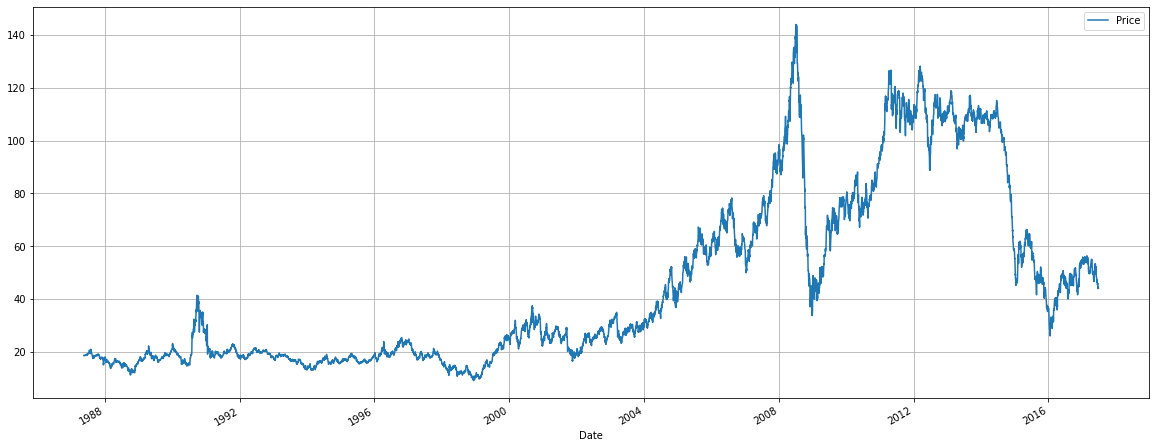

In [ ]:
df.plot(x='Date' , y='Price', figsize=(20,8), grid=True)

In [ ]:
# Creating a column with month and year values extracted from the date column that was converted to datetime data type

df["Year"] = pd.to_datetime(df["Date"]).dt.year 
df["Month"] = pd.to_datetime(df["Date"]).dt.month
df.head(3)

,Date,Price,Year,Month
0,1987-05-20,18.63,1987,5
1,1987-05-21,18.45,1987,5
2,1987-05-22,18.55,1987,5


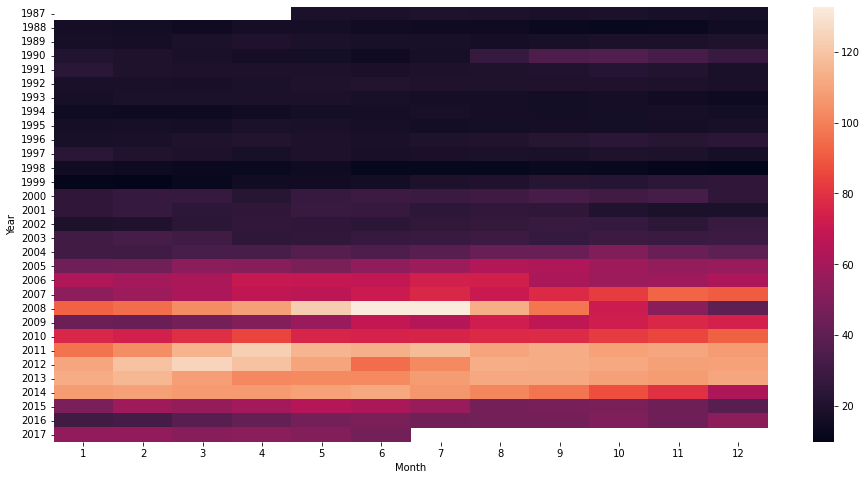

In [ ]:
# Plotting the heat map
plot = df.pivot_table('Price', 'Year', 'Month')
heatMap = sns.heatmap(plot)



---



#LSTM Modeling

In [ ]:
import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential

In [ ]:
df_lstm = df.drop(['Year','Month'], axis=1)
df_lstm.head(3)

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55


##Data Split

In [ ]:
df_lstm.shape

(7641, 2)

In [ ]:
#I want to make the train size and test size able to be divided by 7 for the lstm input shape to be (7,1), so I will remove the last 4 rows

df_lstm = df_lstm[:-4]

train = df_lstm[:6104]
test = df_lstm[6104:]


print('Price_log size : ', df_lstm.shape)
print('train size : ', train.shape)
print('test size : ', test.shape)

print('Train Test Split percentage % : ', (train.shape[0]/df_lstm.shape[0])*100)

Price_log size :  (7637, 2)
train size :  (6104, 2)
test size :  (1533, 2)
Train Test Split percentage % :  79.92667277726856


In [ ]:
df_lstm.iloc[6104]

Date     2011-06-01 00:00:00
Price                 116.15
Name: 6104, dtype: object

In [ ]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)

In [ ]:
test.head(3)

,Price
Date,
2011-06-01,116.15
2011-06-02,114.30
2011-06-03,115.09




---



**Visualizing training and testing data used for LSTM modeling:**

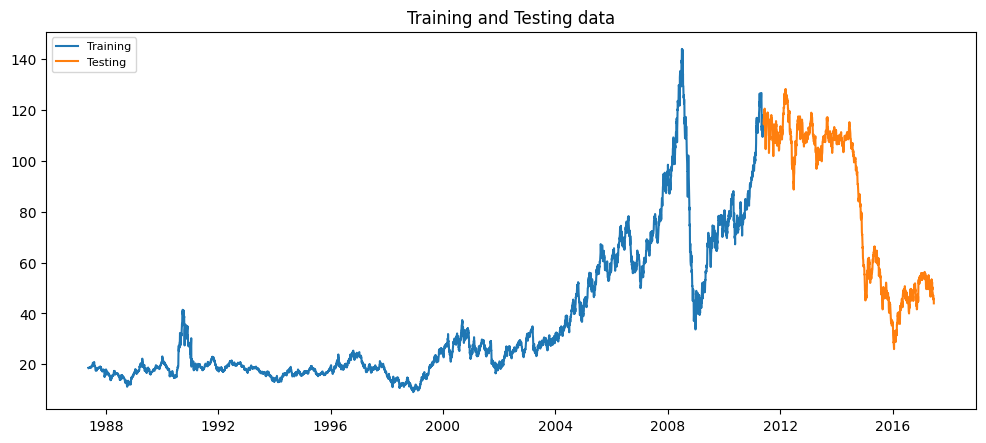

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='Training')
plt.plot(test, label='Testing')
#plt.plot(predict_ser, label='Forecast')
# plt.fill_between(lower_ser.index, lower_ser, upper_ser, 
#                  color='k', alpha=.15)
plt.title('Training and Testing data')
plt.legend(loc='upper left', fontsize=8)

plt.show()



---



**Extracting x and y values for each of Train and Test data**

In [ ]:
def supervised_setup(data, column):
  # data: expects train/test set with 2 dimensions of (samples, features)
  # column: expects integer indicating column index

  X, y = [], [] # start with empty lists for X and y
  input_start = 0 # iterator
  n_input = 7 # we want 7 days as input
  n_out = 7 # we want 7 days as output

  # step over the entire history one time step at a time
  for i in range(len(data)):
	  # define the end of the input and corresponding output
	  input_end = input_start + n_input
	  output_end = input_end + n_out
	
    # ensure we have enough data for this instance
	  if output_end < len(data):
		  x_input = data[input_start:input_end, column]
		  x_input = x_input.reshape((len(x_input), 1))
  
		  X.append(x_input)
		  y.append(data[input_end:output_end, column])
  
	  # move along one time step
	  input_start += 1
  return np.array(X), np.array(y)

In [ ]:
train = train.values
print('Train data shape: ', train.shape)

test = test.values
print('Test data shape: ',test.shape)

Train data shape:  (6104, 1)
Test data shape:  (1533, 1)


In [ ]:
#Reshaping data and extracting y values for the model training and testing
X_train, y_train = supervised_setup(train, 0)
X_test, y_test = supervised_setup(test, 0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6090, 7, 1)
(6090, 7)
(1519, 7, 1)
(1519, 7)


**Viewing some training samples and their relevant testing values:**

In [ ]:
print(X_train[:4])

[[[18.63]
  [18.45]
  [18.55]
  [18.6 ]
  [18.63]
  [18.6 ]
  [18.6 ]]

 [[18.45]
  [18.55]
  [18.6 ]
  [18.63]
  [18.6 ]
  [18.6 ]
  [18.58]]

 [[18.55]
  [18.6 ]
  [18.63]
  [18.6 ]
  [18.6 ]
  [18.58]
  [18.65]]

 [[18.6 ]
  [18.63]
  [18.6 ]
  [18.6 ]
  [18.58]
  [18.65]
  [18.68]]]


In [ ]:
print(y_train[:4])

[[18.58 18.65 18.68 18.75 18.78 18.65 18.75]
 [18.65 18.68 18.75 18.78 18.65 18.75 18.78]
 [18.68 18.75 18.78 18.65 18.75 18.78 18.78]
 [18.75 18.78 18.65 18.75 18.78 18.78 18.68]]




---



##Model Design

In [ ]:
def get_model(params, input_shape):
	model = Sequential()
	model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, 1)))
	model.add(Dropout(rate=params["dropout"]))

	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	model.add(Dropout(rate=params["dropout"]))

	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	model.add(Dropout(rate=params["dropout"]))

	model.add(LSTM(units=params["lstm_units"], return_sequences=False))
	model.add(Dropout(rate=params["dropout"]))

	model.add(Dense(7))

	model.compile(loss=params["loss"],
              	optimizer=params["optimizer"],
              	metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

	return model

In [ ]:
params = {
	"loss": "mean_squared_error",
	"optimizer": "adam",
	"dropout": 0.2,
	"lstm_units": 90,
	"epochs": 30,
	"batch_size": 128
}

model = get_model(params=params, input_shape=X_train.shape[1])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 90)             33120     
                                                                 
 dropout (Dropout)           (None, 7, 90)             0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 90)             65160     
                                                                 
 dropout_1 (Dropout)         (None, 7, 90)             0         
                                                                 
 lstm_2 (LSTM)               (None, 7, 90)             65160     
                                                                 
 dropout_2 (Dropout)         (None, 7, 90)             0         
                                                                 
 lstm_3 (LSTM)               (None, 90)                6

In [ ]:
print('The shape of X_train entering the model is: ', X_train.shape)
print('The shape of y_train entering the model is: ', y_train.shape)

The shape of X_train entering the model is:  (6090, 7, 1)
The shape of y_train entering the model is:  (6090, 7)


In [ ]:
print('one example of X_train is: \n ',X_train[0])
print('one example of y_train is: ',y_train[0])

one example of X_train is: 
  [[18.63]
 [18.45]
 [18.55]
 [18.6 ]
 [18.63]
 [18.6 ]
 [18.6 ]]
one example of y_train is:  [18.58 18.65 18.68 18.75 18.78 18.65 18.75]


In [ ]:
model.fit(
	X_train,
	y_train,
	validation_data=(X_test, y_test),
	epochs=100,
	batch_size=params["batch_size"],
	verbose=1
)

Epoch 1/100
48/48 [==============================] - 15s 133ms/step - loss: 1653.5355 - root_mean_squared_error: 40.6637 - mean_absolute_error: 30.7243 - val_loss: 6512.6538 - val_root_mean_squared_error: 80.7010 - val_mean_absolute_error: 74.7810
Epoch 2/100
48/48 [==============================] - 7s 147ms/step - loss: 1313.5012 - root_mean_squared_error: 36.2423 - mean_absolute_error: 24.7109 - val_loss: 5841.8105 - val_root_mean_squared_error: 76.4317 - val_mean_absolute_error: 70.1526
Epoch 3/100
48/48 [==============================] - 4s 86ms/step - loss: 1120.5867 - root_mean_squared_error: 33.4752 - mean_absolute_error: 20.8710 - val_loss: 5310.3076 - val_root_mean_squared_error: 72.8719 - val_mean_absolute_error: 66.2568
Epoch 4/100
48/48 [==============================] - 4s 84ms/step - loss: 984.7661 - root_mean_squared_error: 31.3810 - mean_absolute_error: 18.6434 - val_loss: 4867.0435 - val_root_mean_squared_error: 69.7642 - val_mean_absolute_error: 62.8234
Epoch 5/100
48

##Model Forecasting

In [ ]:
# make a single prediction
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	
  # retrieve last observations for input data
	input_x = data[-n_input:, 0]

  # reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))

  # forecast the next week
	predicted_y = model.predict(input_x, verbose=0)

  # we only want the vector forecast
	predicted_y = predicted_y[0]
	return predicted_y

In [ ]:
# To start evaluating our model, we can start from the last week in our training data
history = [x for x in X_train] # converting history into a list
n_input = 7

# We do walk-forward validation for each week
predictions = []
	
for i in range(len(X_test)):
	# predict the week
	y_predicted = forecast(model, history, n_input) 
	# collect predictions
	predictions.append(y_predicted)
	# get real observation and add it to my history 
	history.append(X_test[i,:])

In [ ]:
#Recall data statistics

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6090, 7, 1)
(6090, 7)
(1519, 7, 1)
(1519, 7)


In [ ]:
#viewing one example of the generated predictions
y_predicted

array([47.966103, 48.18417 , 48.01706 , 48.075848, 48.154102, 48.30038 ,
       48.1484  ], dtype=float32)



---



##Model Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error

# Now, we want to evaluate our model
predictions = np.array(predictions) # converting from list to np.array

# But we want to see how well our model is doing day by day 
scores = []
# calculate an RMSE score for each day
for i in range(y_test.shape[1]): # Loop over the days of each week (shape[1] refers to the days)
  # calculate mse for each day
  mse = mean_squared_error(y_test[:, i], predictions[:, i])
  rmse = np.sqrt(mse)
	# store
  scores.append(rmse)
 
# calculate overall RMSE for the entire week
weekly_score = np.array(scores).mean()
print('weekly score is: ', weekly_score )

weekly score is:  3.936025278777599


[AVG] ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']: 
 [3.936] [3.1903893749984165, 3.478976732434226, 3.792506456484936, 3.9563077576618406, 4.044569291856828, 4.434637354890302, 4.654789983116642]


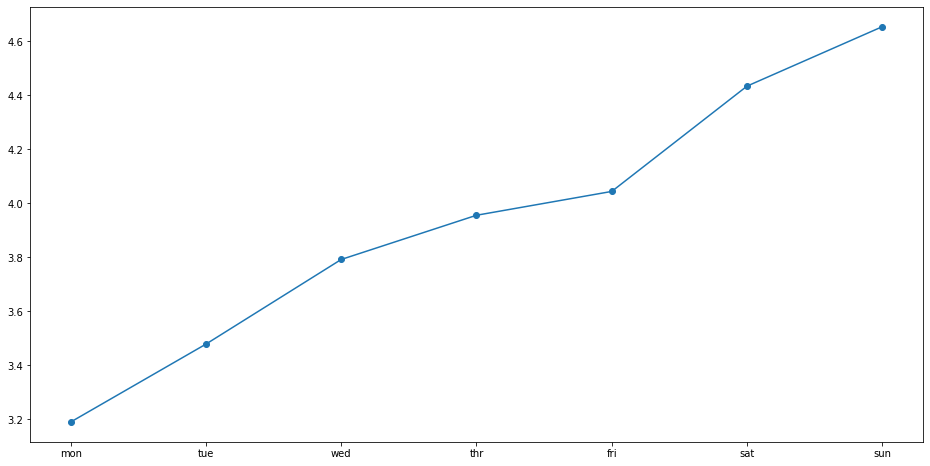

In [ ]:
# print and plot scores
days = ['mon', 'tue', 'wed', 'thr', 'fri', 'sat', 'sun']
print('[AVG] %s: \n [%.3f] %s' % (days, weekly_score, scores))

plt.plot(days, scores, marker='o', label='lstm')
plt.show()



---



##Visual validation of model performance: Predictions versus Observations

In [ ]:
# storing observations and model outputs in dataframes
true = pd.DataFrame(y_test[:,0]) # first day 2011-06-01
pred = pd.DataFrame(predictions[:,0])

In [ ]:
true

,0
0,118.71
1,120.49
2,120.35
3,114.67
4,114.69
...,...
1514,48.25
1515,48.11
1516,47.08
1517,46.30


In [ ]:
pred

,0
0,115.786751
1,117.038475
2,117.063499
3,117.080231
4,117.090103
...,...
1514,50.618538
1515,49.804108
1516,49.145569
1517,48.705917


In [ ]:
#Getting the date of the bginning of test data
df_lstm.iloc[6104]

Date     2011-06-01 00:00:00
Price                 116.15
Name: 6104, dtype: object

In [ ]:
# creating a datetime index for the dataframes
dti = pd.date_range('2011-06-01', periods=1517, freq='D') # first day of test samples: 2011-06-01

In [ ]:
dti

DatetimeIndex(['2011-06-01', '2011-06-02', '2011-06-03', '2011-06-04',
               '2011-06-05', '2011-06-06', '2011-06-07', '2011-06-08',
               '2011-06-09', '2011-06-10',
               ...
               '2015-07-17', '2015-07-18', '2015-07-19', '2015-07-20',
               '2015-07-21', '2015-07-22', '2015-07-23', '2015-07-24',
               '2015-07-25', '2015-07-26'],
              dtype='datetime64[ns]', length=1517, freq='D')

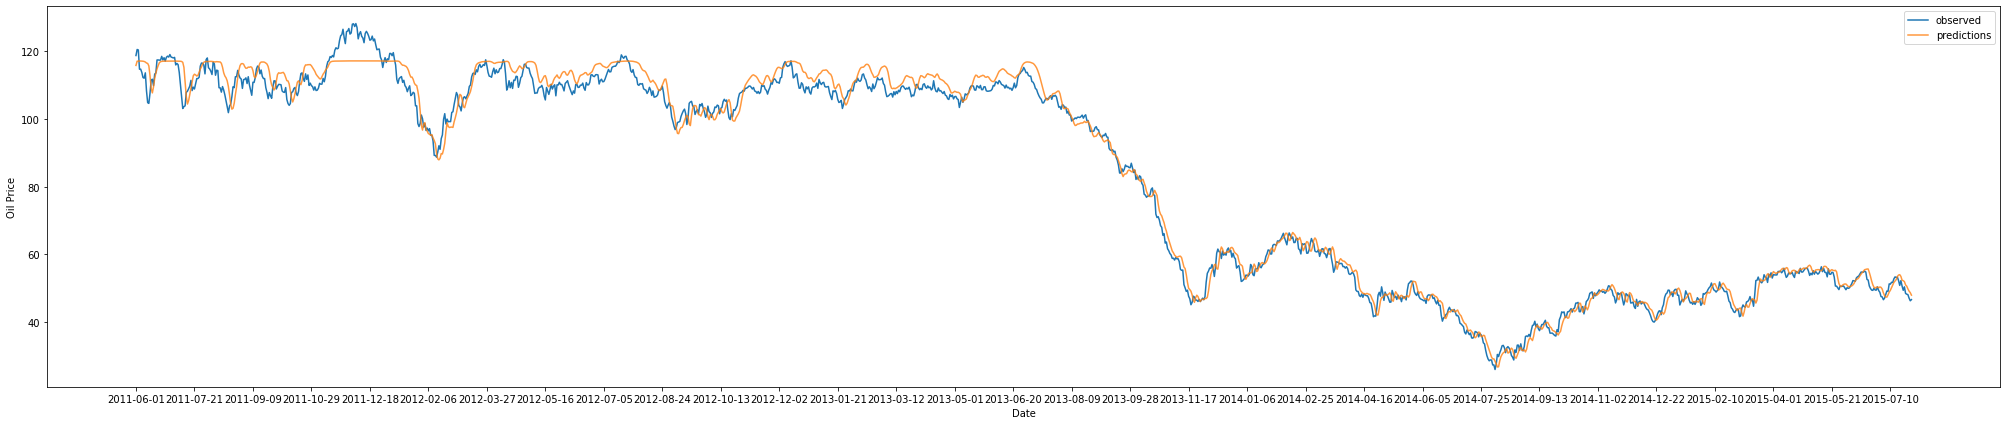

In [ ]:
# overlay observed sequence and predicted sequence
ax = true.plot()
pred.plot(ax=ax, alpha=.8, figsize=(35, 7))

xi = list(range(len(dti)))
plt.xticks(np.arange(min(xi), max(xi), 50), dti.date[np.arange(min(xi), max(xi), 50)])

ax.set_xlabel('Date')
ax.set_ylabel('Oil Price')
plt.legend(['observed','predictions'])
plt.show()

**Significant results!**